# Librerias a utilizar

In [53]:
import os
import time
import random
import numpy as np
import matplotlib.pyplot as plt

# Conjunto de datos

In [54]:
# Vector de ciudades --> Quito las tildes por comodidad
CIUDADES = ["Alicante","Barcelona","Bilbao","Caceres","Cadiz","Cordoba",
"Coruna","Girona","Huelva","Leon","Madrid","Murcia","Oviedo",
"Pamplona","Donostia","Sevilla","Tarragona","Toledo","Valencia",
"Zaragoza"]

# Numero de ciudades
NUM_CIUDADES = len(CIUDADES)

# Matriz de distancias
M = [
[0,515,817,675,688,525,1031,615,703,855,422,75,873,673,766,609,417,411,166,498],
[515,0,620,918,1284,908,1118,100,1140,784,621,590,902,437,529,1046,98,692,349,296],
[817,620,0,605,1058,795,644,720,939,359,395,796,304,159,119,993,555,466,633,324],
[675,918,605,0,369,319,683,1018,323,407,297,654,525,650,679,264,831,264,636,622],
[688,1284,1058,369,0,263,1072,1384,219,796,663,613,914,1070,1132,125,1059,583,808,988],
[525,908,795,319,263,0,995,1008,232,733,400,444,851,807,869,138,796,320,545,725],
[1031,1118,644,683,1072,995,0,1218,1006,334,609,1010,340,738,763,947,1064,675,961,833],
[615,100,720,1018,1384,1008,1218,0,1240,884,721,690,1002,537,629,1146,198,792,449,396],
[703,1140,939,323,219,232,1006,1240,0,730,632,628,821,1039,1101,94,1029,552,791,957],
[855,784,359,407,796,733,334,884,730,0,333,734,118,404,433,671,719,392,685,488],
[422,621,395,297,663,400,609,721,632,333,0,401,451,407,469,538,534,71,352,325],
[75,590,796,654,613,444,1010,690,628,734,401,0,852,714,807,534,492,390,241,539],
[873,902,304,525,914,851,340,1002,821,118,451,852,0,463,423,789,835,510,803,604],
[673,437,159,650,1070,807,738,537,1039,404,407,714,463,0,92,945,372,478,501,175],
[766,529,119,679,1132,869,763,629,1101,433,469,807,423,92,0,1007,464,540,594,268],
[609,1046,993,264,125,138,947,1146,94,671,538,534,789,945,1007,0,949,458,697,863],
[417,98,555,831,1059,796,1064,198,1029,719,534,492,835,372,464,949,0,605,251,231],
[411,692,466,264,583,320,675,792,552,392,71,390,510,478,540,458,605,0,372,396],
[166,349,633,636,808,545,961,449,791,685,352,241,803,501,594,697,251,372,0,326],
[498,296,324,622,988,725,833,396,957,488,325,539,604,175,268,863,231,396,326,0]
]

# Implementacion de las funciones a utilizar

### Funcion para la inicializacion de la poblacion

In [3]:
# Función de inicialización de población --> Genera rutas aleatorias
def inicializar_poblacion(tam_poblacion, ciudadInicial):
    # Paso la ciudad como parametro, para poder elegir cualquir otra, en vez de pamplona.
    poblacion = []
    indiceCiudadInicial = CIUDADES.index(ciudadInicial)  # Obtengo el índice de la ciudad inicial (Pamplona) con su nombre, para que si se cambia el vector de ciudades siga funcionando
    for _ in range(tam_poblacion):
        ruta = list(range(NUM_CIUDADES))
        ruta.remove(indiceCiudadInicial)  # Elimino Pamplona de la lista de ciudades
        random.shuffle(ruta)
        ruta.insert(0, indiceCiudadInicial)  # Inserto Pamplona al inicio de la ruta
        ruta.append(indiceCiudadInicial)  # Inserto Pamplona al final de la ruta
        poblacion.append(ruta)
    return poblacion

### Funcion para la evaluacion de la poblacion

In [4]:
# Función de evaluación de la población --> Calcula el coste de las rutas
def evaluar_poblacion(poblacion):
    evaluaciones = []
    for individuo in poblacion:
        costo = calcular_costo(individuo)
        evaluaciones.append((individuo, costo))
    return evaluaciones

### Funcion para calcular el costo de un cromosoma

In [94]:
# Función para calcular el costo de una ruta
def calcular_costo(ruta):
    costo = 0
    for i in range(len(ruta) - 1):
        ciudad_actual = ruta[i]
        siguiente_ciudad = ruta[i + 1]
        costo += M[ciudad_actual][siguiente_ciudad]
    costo += M[ruta[-1]][ruta[0]]  # Calculo el costo de regresar al punto de partida
    return costo

### Funcion para la seleccion de progenitores que deben reproducirse

In [82]:
def seleccionar_progenitores_ruleta(poblacion_evaluada):
    total_costos = sum(costo for _, costo in poblacion_evaluada)
    seleccionados = []
    for i in range(len(poblacion_evaluada)):
        r = random.uniform(0, total_costos)
        acumulado = 0
        for individuo, costo in poblacion_evaluada: # Compruebo si r esta dentro de el intevalo de este individuo 
            acumulado += costo
            if acumulado >= r:
                seleccionados.append(individuo)
                break
    return seleccionados

def seleccionar_progenitores_torneo(poblacion_evaluada, k, con_reemplazo):
    seleccionados = []
    for _ in range(len(poblacion_evaluada)):
        if con_reemplazo:
            participantes = random.choices(poblacion_evaluada, k=k)  # Selecciono k individuos aleatorios con reemplazo
        else:
            participantes = random.sample(poblacion_evaluada, k)  # Selecciono k individuos aleatorios sin reemplazo
        ganador = min(participantes, key=lambda x: x[1])  # Selecciono el individuo con menor costo
        seleccionados.append(ganador[0])  # Agrego el individuo seleccionado
    return seleccionados

### Funcion de cruzamiento para crear descendencia geneticamente diversa

In [83]:
def cruzamiento_pmx(cromosoma1, cromosoma2):
    if len(cromosoma1) != len(cromosoma2):
        raise ValueError("Los cromosomas deben tener la misma longitud")
    
    # Elimino Pamplona del principio y final de los cromosomas
    ciudadInicial = cromosoma1[0] # Guardo la ciudad para añadirla mas tarde
    cromosoma1 = cromosoma1[1:-1]
    cromosoma2 = cromosoma2[1:-1]
    
    descendiente1 = [-1] * len(cromosoma1)
    descendiente2 = [-1] * len(cromosoma1)
    
    # Selecciono dos puntos de cruzamiento al azar
    punto1 = random.randint(0, len(cromosoma1) - 1)
    punto2 = random.randint(0, len(cromosoma1) - 1)

    if punto1 > punto2:
        punto1, punto2 = punto2, punto1
    
    # Copio el segmento entre los puntos de cruzamiento de los padres al primer descendiente
    descendiente1[punto1:punto2 + 1] = cromosoma1[punto1:punto2 + 1]
    descendiente2[punto1:punto2 + 1] = cromosoma2[punto1:punto2 + 1]

    # Mapeo de los elementos no copiados de P2 a P1
    for i in range(punto1, punto2 + 1):
        if cromosoma2[i] not in descendiente1:
            index = i
            while cromosoma1[index] in descendiente1[punto1:punto2 + 1]:
                index = cromosoma2.index(cromosoma1[index])
            descendiente1[index] = cromosoma2[i]

    # Mapeo de los elementos no copiados de P1 a P2
    for i in range(punto1, punto2 + 1):
        if cromosoma1[i] not in descendiente2:
            index = i
            while cromosoma2[index] in descendiente2[punto1:punto2 + 1]:
                index = cromosoma1.index(cromosoma2[index])
            descendiente2[index] = cromosoma1[i]

    # Relleno los elementos restantes de los descendientes
    for i in range(len(cromosoma1)):
        if descendiente1[i] == -1:
            descendiente1[i] = cromosoma2[i]
        if descendiente2[i] == -1:
            descendiente2[i] = cromosoma1[i]
            
    # Inserto Pamplona al principio y al final de los descendientes
    descendiente1.insert(0, ciudadInicial)
    descendiente1.append(ciudadInicial)
    descendiente2.insert(0, ciudadInicial)
    descendiente2.append(ciudadInicial)

    return descendiente1, descendiente2

def cruzamiento_basado_en_orden(cromosoma1, cromosoma2):
    if len(cromosoma1) != len(cromosoma2):
        raise ValueError("Los cromosomas deben tener la misma longitud")
        
    # Elimino Pamplona del principio y final de los cromosomas
    ciudadInicial = cromosoma1[0] # Guardo la ciudad para añadirla mas tarde
    cromosoma1 = cromosoma1[1:-1]
    cromosoma2 = cromosoma2[1:-1]
    
    descendiente1 = [-1] * len(cromosoma1)
    descendiente2 = [-1] * len(cromosoma1)
    
    # Selecciono dos puntos de cruzamiento al azar
    punto1 = random.randint(0, len(cromosoma1) - 1)
    punto2 = random.randint(0, len(cromosoma1) - 1)
    if punto1 > punto2:
        punto1, punto2 = punto2, punto1
    
    # Copio el segmento entre los puntos de cruzamiento de los padres al primer descendiente
    descendiente1[punto1:punto2 + 1] = cromosoma1[punto1:punto2 + 1]
    descendiente2[punto1:punto2 + 1] = cromosoma2[punto1:punto2 + 1]
    
     # Copio en orden los valores del primer progenitor que todavía no han aparecido en el primer descendiente
    indexDescendiente = (punto2 + 1) % len(cromosoma2)
    index2 = (punto2 + 1) % len(cromosoma2)
    for i in range(len(cromosoma2)):
        if cromosoma2[index2] not in descendiente1:
            descendiente1[indexDescendiente] = cromosoma2[index2]
            # Solo avanzo si he escrito
            indexDescendiente = (indexDescendiente + 1) % len(cromosoma2)
            index2 = (index2 + 1) % len(cromosoma2)
        else:
            index2 = (index2 + 1) % len(cromosoma2)
    
    # Copio en orden los valores del primer progenitor que todavía no han aparecido en el segundo descendiente
    indexDescendiente2 = (punto2 + 1) % len(cromosoma1)
    index1 = (punto2 + 1) % len(cromosoma1)
    for i in range(len(cromosoma1)):
        if cromosoma1[index1] not in descendiente2:
            descendiente2[indexDescendiente2] = cromosoma1[index1]
            # Solo avanzo si he escrito
            indexDescendiente2 = (indexDescendiente2 + 1) % len(cromosoma1)
            index1 = (index1 + 1) % len(cromosoma1)
        else:
            index1 = (index1 + 1) % len(cromosoma1)
    
    # Inserto Pamplona al principio y al final de los descendientes
    descendiente1.insert(0, ciudadInicial)
    descendiente1.append(ciudadInicial)
    descendiente2.insert(0, ciudadInicial)
    descendiente2.append(ciudadInicial)

    return descendiente1, descendiente2

### Funcion para implementar mutaciones a la descendencia, para aumentar la diversidad genetica

In [84]:
def mutacion_por_intercambio(cromosoma): 
    # Escojo dos posiciones aleatorias que no sean la primera ni ultima(pamplona)
    pos1, pos2 = random.sample(range(1, len(cromosoma)-1), 2)
    # Intercambio los valores en esas posiciones
    cromosoma[pos1], cromosoma[pos2] = cromosoma[pos2], cromosoma[pos1]
    return cromosoma

def mutacion_por_insercion(cromosoma):
    # Escojo dos genes aleatorios que no sean el primero ni el ultimo(pamplona)
    gen1, gen2 = random.sample(range(1, len(cromosoma)-1), 2)
    # Muevo uno de los genes para juntarlo con el otro
    if gen1 > gen2:
        gen_que_mueve = cromosoma.pop(gen1)
        cromosoma.insert(gen2 + 1, gen_que_mueve)
    else:
        gen_que_mueve = cromosoma.pop(gen2)
        cromosoma.insert(gen1 + 1, gen_que_mueve)
    return cromosoma

### Funcion para seleccionar la descendencia mas prometedora

In [85]:
def seleccionar_supervivientes(poblacion, descendientes):
    tamPoblacionFinal = len(poblacion)
    # Selecciono los mejores individuos de entre la población actual y los descendientes
    poblacion.extend(descendientes)
    poblacion.sort(key=lambda x: calcular_costo(x))  # Ordeno la población por costo
    nueva_generacion = poblacion[:tamPoblacionFinal]  # Tomo los mejores individuos como la nueva generación
    return nueva_generacion

### Funcion para almacenar los resultados obtenidos y poder graficarlos

In [86]:
def almacenar_resultado(resultados, nombre_cruce, nombre_seleccion, mejor_costo, mejor_iteracion, tiempo_mejor_resultado, k, usarK, mejores_costos):
    if usarK:
        combinacion = f"{nombre_cruce} - {nombre_seleccion} - {k}"
        resultados[combinacion] = (mejor_costo, mejor_iteracion, tiempo_mejor_resultado, mejores_costos)  # Guardar mejores costos como una lista
    else:
        combinacion = f"{nombre_cruce} - {nombre_seleccion}"
        resultados[combinacion] = (mejor_costo, mejor_iteracion, tiempo_mejor_resultado, mejores_costos)  # Guardar mejores costos como una lista


# Algoritmos

### Algoritmo genetico sin mutaciones

In [87]:
def algoritmo_genetico_sin_mutaciones(tam_poblacion, num_generaciones, ciudadInicial, funcion_cruce, funcion_seleccion, k):
    poblacion = inicializar_poblacion(tam_poblacion, ciudadInicial)
    mejores_costos = []  # Lista para almacenar los mejores costos en cada iteración
    mejor_resultado = float('inf')
    mejor_iteracion = -1
    tiempo_mejor_resultado = 0
    inicio = time.time()
    for generacion in range(num_generaciones):
        poblacion_evaluada = evaluar_poblacion(poblacion)
        if k == None:
            progenitores = funcion_seleccion(poblacion_evaluada)
        else:
            progenitores = funcion_seleccion(poblacion_evaluada, k, True)
        poblacion_nueva = []
        while len(poblacion_nueva) < tam_poblacion:
            padre1, padre2 = random.sample(progenitores, 2)
            hijo1, hijo2 = funcion_cruce(padre1, padre2)
            poblacion_nueva.append(hijo1)
            poblacion_nueva.append(hijo2)
        poblacion = seleccionar_supervivientes(poblacion, poblacion_nueva)
        mejor_ruta, mejor_costo = min(evaluar_poblacion(poblacion), key=lambda x: x[1])
        mejores_costos.append(mejor_costo)  # Guardo el mejor costo en esta iteración
        if mejor_costo < mejor_resultado:
            mejor_resultado = mejor_costo
            mejor_iteracion = generacion
            tiempo_mejor_resultado = time.time() - inicio
    return mejor_ruta, mejor_costo, mejor_iteracion, tiempo_mejor_resultado, mejores_costos  # Devuelvo también la lista de mejores costos

def ejecutar_algoritmo_genetico_sin_mutaciones(tam_poblacion, num_generaciones, ciudadInicial, valores_k, funciones_cruce, funciones_seleccion):
    resultados_sin_mutaciones = {}
    for funcion_cruce, nombre_cruce in funciones_cruce.items():
        for funcion_seleccion, nombre_seleccion in funciones_seleccion.items():
            if nombre_seleccion == "seleccionar_progenitores_torneo":
                for k in valores_k:
                    print("Función de cruce:", nombre_cruce)
                    print("Función de selección de progenitores:", nombre_seleccion)
                    print("Valor de k:", k)
                    mejor_ruta, mejor_costo, mejor_iteracion, tiempo_mejor_resultado, mejores_costos = algoritmo_genetico_sin_mutaciones(
                    tam_poblacion, num_generaciones, ciudadInicial, funcion_cruce, funcion_seleccion, k)
                    almacenar_resultado(resultados_sin_mutaciones, nombre_cruce, nombre_seleccion, mejor_costo, mejor_iteracion, tiempo_mejor_resultado, k, 1, mejores_costos)
                    print("Mejor ruta encontrada:", [CIUDADES[i] for i in mejor_ruta])
                    print("Costo de la mejor ruta:", mejor_costo)
                    print("Iteración de mejor resultado:", mejor_iteracion)
                    print("Tiempo en que se encontró el mejor resultado:", tiempo_mejor_resultado)
                    print("\n-----------------------------\n")
            else:
                print("Función de cruce:", nombre_cruce)
                print("Función de selección de progenitores:", nombre_seleccion)
                mejor_ruta, mejor_costo, mejor_iteracion, tiempo_mejor_resultado, mejores_costos = algoritmo_genetico_sin_mutaciones(
                tam_poblacion, num_generaciones, ciudadInicial, funcion_cruce, funcion_seleccion, None)
                almacenar_resultado(resultados_sin_mutaciones, nombre_cruce, nombre_seleccion, mejor_costo, mejor_iteracion, tiempo_mejor_resultado, None, 0, mejores_costos)
                print("Mejor ruta encontrada:", [CIUDADES[i] for i in mejor_ruta])
                print("Costo de la mejor ruta:", mejor_costo)
                print("Iteración de mejor resultado:", mejor_iteracion)
                print("Tiempo en que se encontró el mejor resultado:", tiempo_mejor_resultado)
                print("\n-----------------------------\n")
    return resultados_sin_mutaciones

### Algoritmo genetico con mutaciones

In [88]:
def algoritmo_genetico_con_mutaciones(tam_poblacion, num_generaciones, ciudadInicial, funcion_cruce, funcion_seleccion, k):
    poblacion = inicializar_poblacion(tam_poblacion, ciudadInicial)
    mejores_costos = []  # Lista para almacenar los mejores costos en cada iteración
    mejor_resultado = float('inf')
    mejor_iteracion = -1
    tiempo_mejor_resultado = 0
    inicio = time.time()
    for generacion in range(num_generaciones):
        poblacion_evaluada = evaluar_poblacion(poblacion)
        if k == None:
            progenitores = funcion_seleccion(poblacion_evaluada)
        else:
            progenitores = funcion_seleccion(poblacion_evaluada, k, True)
        poblacion_nueva = []
        while len(poblacion_nueva) < tam_poblacion:
            padre1, padre2 = random.sample(progenitores, 2)
            hijo1, hijo2 = funcion_cruce(padre1, padre2)
            hijo1 = mutacion_por_intercambio(hijo1)
            hijo2 = mutacion_por_insercion(hijo2)
            poblacion_nueva.append(hijo1)
            poblacion_nueva.append(hijo2)
        poblacion = seleccionar_supervivientes(poblacion, poblacion_nueva)
        mejor_ruta, mejor_costo = min(evaluar_poblacion(poblacion), key=lambda x: x[1])
        mejores_costos.append(mejor_costo)  # Guardo el mejor costo en esta iteración
        if mejor_costo < mejor_resultado:
            mejor_resultado = mejor_costo
            mejor_iteracion = generacion
            tiempo_mejor_resultado = time.time() - inicio
    return mejor_ruta, mejor_costo, mejor_iteracion, tiempo_mejor_resultado, mejores_costos  # Devuelvo también la lista de mejores costos


def ejecutar_algoritmo_genetico_mutaciones(tam_poblacion, num_generaciones, ciudadInicial, valores_k, funciones_cruce, funciones_seleccion):
    resultados_con_mutaciones = {}
    for funcion_cruce, nombre_cruce in funciones_cruce.items():
        for funcion_seleccion, nombre_seleccion in funciones_seleccion.items():
            if nombre_seleccion == "seleccionar_progenitores_torneo":
                for k in valores_k:
                    print("Función de cruce:", nombre_cruce)
                    print("Función de selección de progenitores:", nombre_seleccion)
                    print("Valor de k:", k)
                    mejor_ruta, mejor_costo, mejor_iteracion, tiempo_mejor_resultado, mejores_costos = algoritmo_genetico_con_mutaciones(tam_poblacion, num_generaciones, ciudadInicial, funcion_cruce, funcion_seleccion, k)
                    almacenar_resultado(resultados_con_mutaciones, nombre_cruce, nombre_seleccion, mejor_costo, mejor_iteracion, tiempo_mejor_resultado, k, 1, mejores_costos)
                    print("Mejor ruta encontrada:", [CIUDADES[i] for i in mejor_ruta])
                    print("Costo de la mejor ruta:", mejor_costo)
                    print("Iteración de mejor resultado:", mejor_iteracion)
                    print("Tiempo en que se encontró el mejor resultado:", tiempo_mejor_resultado)
                    print("\n-----------------------------\n")
            else:
                print("Función de cruce:", nombre_cruce)
                print("Función de selección de progenitores:", nombre_seleccion)
                mejor_ruta, mejor_costo, mejor_iteracion, tiempo_mejor_resultado, mejores_costos = algoritmo_genetico_con_mutaciones(tam_poblacion, num_generaciones, ciudadInicial, funcion_cruce, funcion_seleccion, None)
                almacenar_resultado(resultados_con_mutaciones, nombre_cruce, nombre_seleccion, mejor_costo, mejor_iteracion, tiempo_mejor_resultado, None, 0, mejores_costos)
                print("Mejor ruta encontrada:", [CIUDADES[i] for i in mejor_ruta])
                print("Costo de la mejor ruta:", mejor_costo)
                print("Iteración de mejor resultado:", mejor_iteracion)
                print("Tiempo en que se encontró el mejor resultado:", tiempo_mejor_resultado)
                print("\n-----------------------------\n")
    return resultados_con_mutaciones

# Funciones para graficar los resultados

In [89]:
# Directorio para guardar las imágenes
output_directory = "resultados_graficos"

# Compruebo si el directorio existe, si no, lo creo
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

def graficar_evolucion_costos(resultados, nombre_archivo):
    plt.figure(figsize=(12, 8))
    for combinacion, (_, _, _, mejores_costos) in resultados.items():
        plt.plot(range(1, len(mejores_costos) + 1), mejores_costos, label=combinacion)
    plt.title("Evolución de los costos por generación")
    plt.xlabel("Generación")
    plt.ylabel("Mejor costo")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(output_directory, nombre_archivo))  # Guardo la imagen
    plt.show()

def graficar_resultados(resultados, nombre_archivo):
    plt.figure(figsize=(14, 10))
    nombres_combinaciones = list(resultados.keys())
    costos = [resultado[0] for resultado in resultados.values()]
    plt.bar(range(len(nombres_combinaciones)), costos, align='center')
    plt.xticks(range(len(nombres_combinaciones)), nombres_combinaciones, rotation=45, ha='right')
    plt.title('Resultados del algoritmo genético')
    plt.xlabel('Combinación de funciones de cruce y selección de progenitores')
    plt.ylabel('Mejor costo encontrado')
    for i, valor in enumerate(costos):
        plt.text(i, valor + 0.1, str(round(valor, 2)), ha='center', va='bottom')
    plt.tight_layout()
    plt.savefig(os.path.join(output_directory, nombre_archivo))  # Guardo la imagen
    plt.show()

def graficar_numero_iteraciones(resultados, nombre_archivo):
    plt.figure(figsize=(14, 7))
    nombres_combinaciones = list(resultados.keys())
    iteraciones = [resultado[1] for resultado in resultados.values()]
    plt.bar(range(len(nombres_combinaciones)), iteraciones, align='center',  color='green')
    plt.xticks(range(len(nombres_combinaciones)), nombres_combinaciones, rotation=45, ha='right')
    plt.title('Número de iteraciones por combinación de funciones de cruce y selección')
    plt.xlabel('Combinación de funciones de cruce y selección de progenitores')
    plt.ylabel('Número de iteraciones')
    for i, valor in enumerate(iteraciones):
        plt.text(i, valor + 0.1, str(valor), ha='center', va='bottom')
    plt.tight_layout()
    plt.savefig(os.path.join(output_directory, nombre_archivo))  # Guardo la imagen
    plt.show()

def graficar_tiempo_ejecucion(resultados, nombre_archivo):
    plt.figure(figsize=(14, 7))
    nombres_combinaciones = list(resultados.keys())
    tiempos = [resultado[2] for resultado in resultados.values()]
    plt.bar(range(len(nombres_combinaciones)), tiempos, align='center', color='orange')
    plt.xticks(range(len(nombres_combinaciones)), nombres_combinaciones, rotation=45, ha='right')
    plt.title('Tiempo de ejecución por combinación de funciones de cruce y selección')
    plt.xlabel('Combinación de funciones de cruce y selección de progenitores')
    plt.ylabel('Tiempo de ejecución (s)')
    for i, valor in enumerate(tiempos):
        plt.text(i, valor, str(round(valor, 2)), ha='center', va='bottom')
    plt.subplots_adjust(bottom=0.2, top=0.9)  
    plt.savefig(os.path.join(output_directory, nombre_archivo))  # Guardo la imagen
    plt.show()

# Ejecucion

### Algoritmo genetico sin mutaciones

Función de cruce: cruzamiento_pmx
Función de selección de progenitores: seleccionar_progenitores_ruleta
Mejor ruta encontrada: ['Pamplona', 'Donostia', 'Madrid', 'Toledo', 'Valencia', 'Girona', 'Barcelona', 'Tarragona', 'Zaragoza', 'Alicante', 'Murcia', 'Cordoba', 'Cadiz', 'Sevilla', 'Huelva', 'Caceres', 'Leon', 'Coruna', 'Oviedo', 'Bilbao', 'Pamplona']
Costo de la mejor ruta: 5248
Iteración de mejor resultado: 31
Tiempo en que se encontró el mejor resultado: 0.0820159912109375

-----------------------------

Función de cruce: cruzamiento_pmx
Función de selección de progenitores: seleccionar_progenitores_torneo
Valor de k: 2
Mejor ruta encontrada: ['Pamplona', 'Oviedo', 'Coruna', 'Sevilla', 'Cadiz', 'Huelva', 'Toledo', 'Leon', 'Valencia', 'Zaragoza', 'Barcelona', 'Tarragona', 'Girona', 'Murcia', 'Alicante', 'Cordoba', 'Caceres', 'Madrid', 'Donostia', 'Bilbao', 'Pamplona']
Costo de la mejor ruta: 7294
Iteración de mejor resultado: 1
Tiempo en que se encontró el mejor resultado: 0.004985

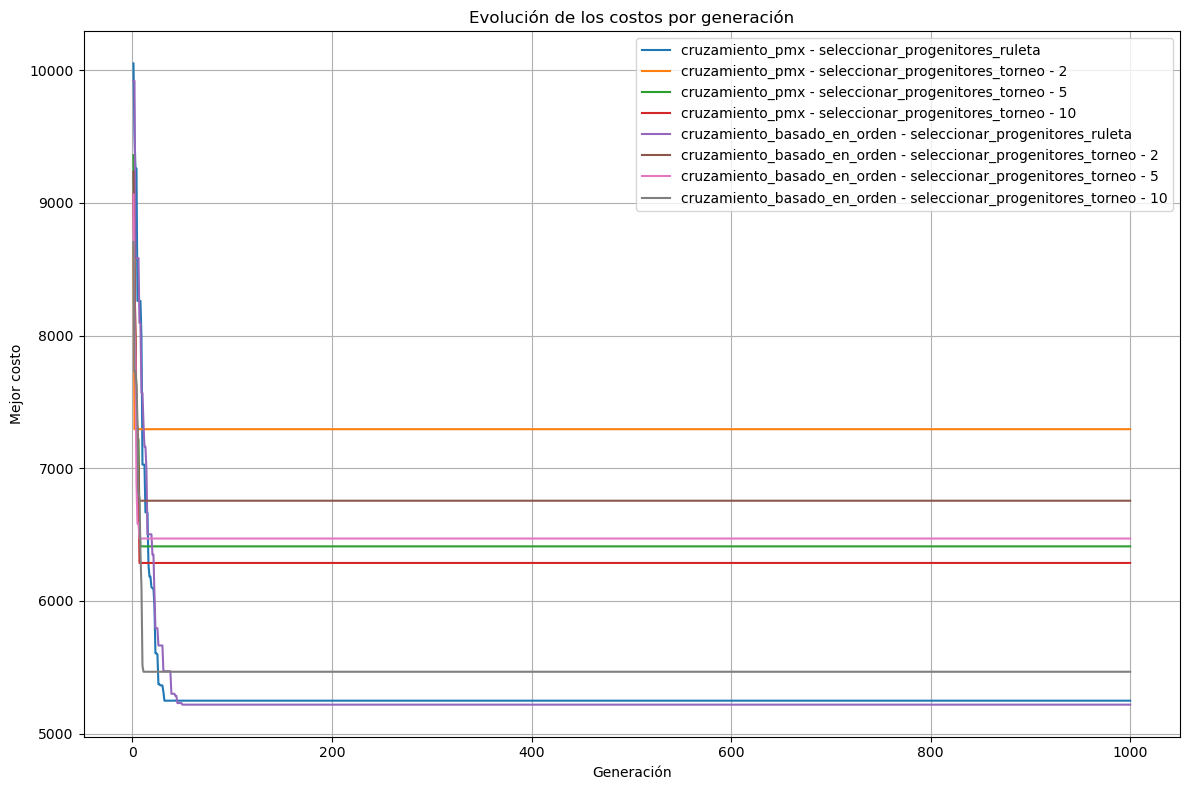

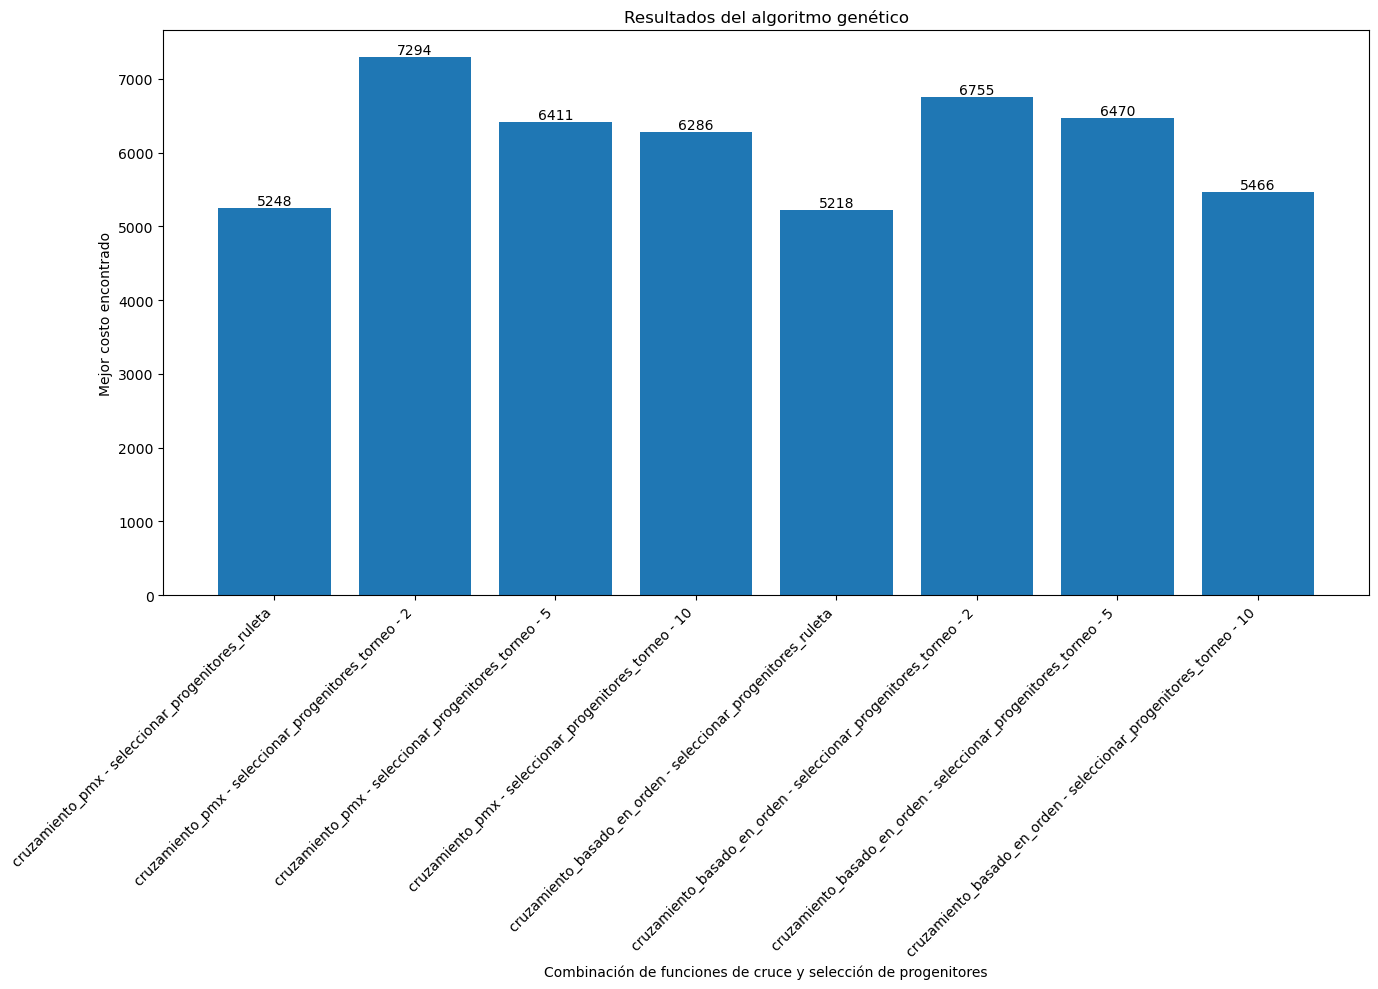

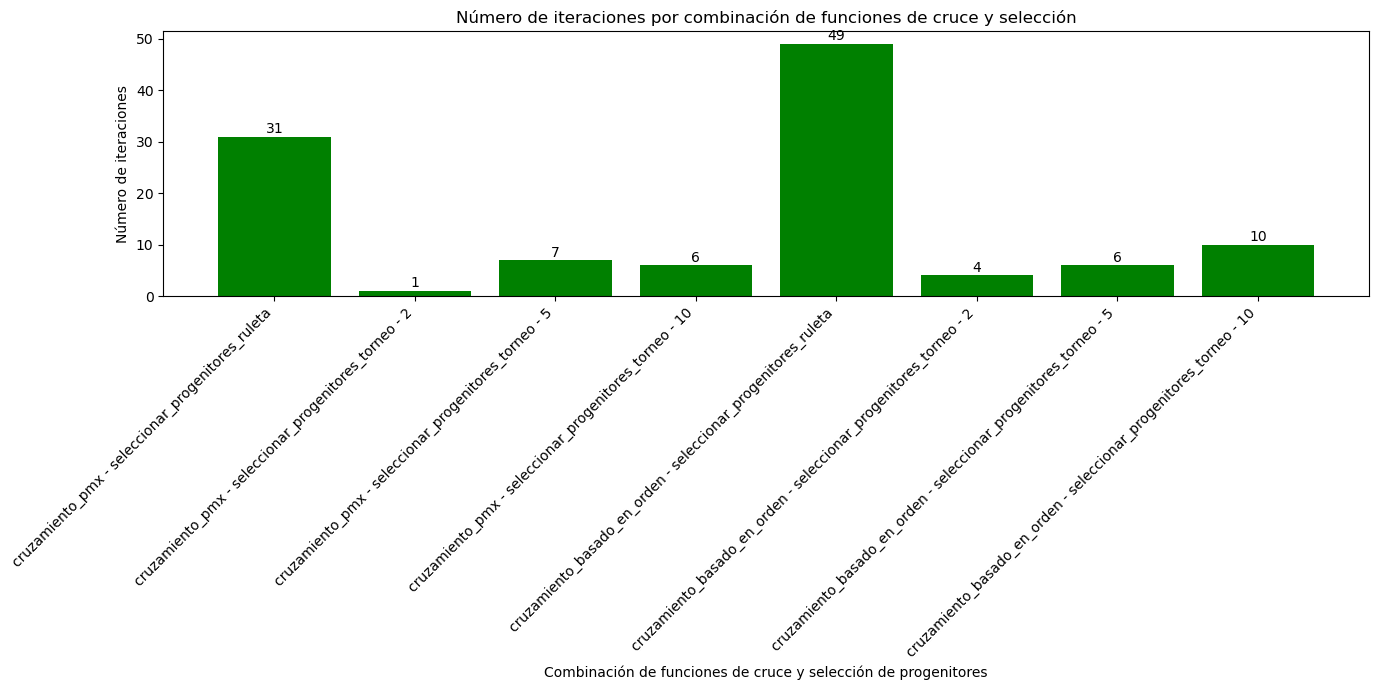

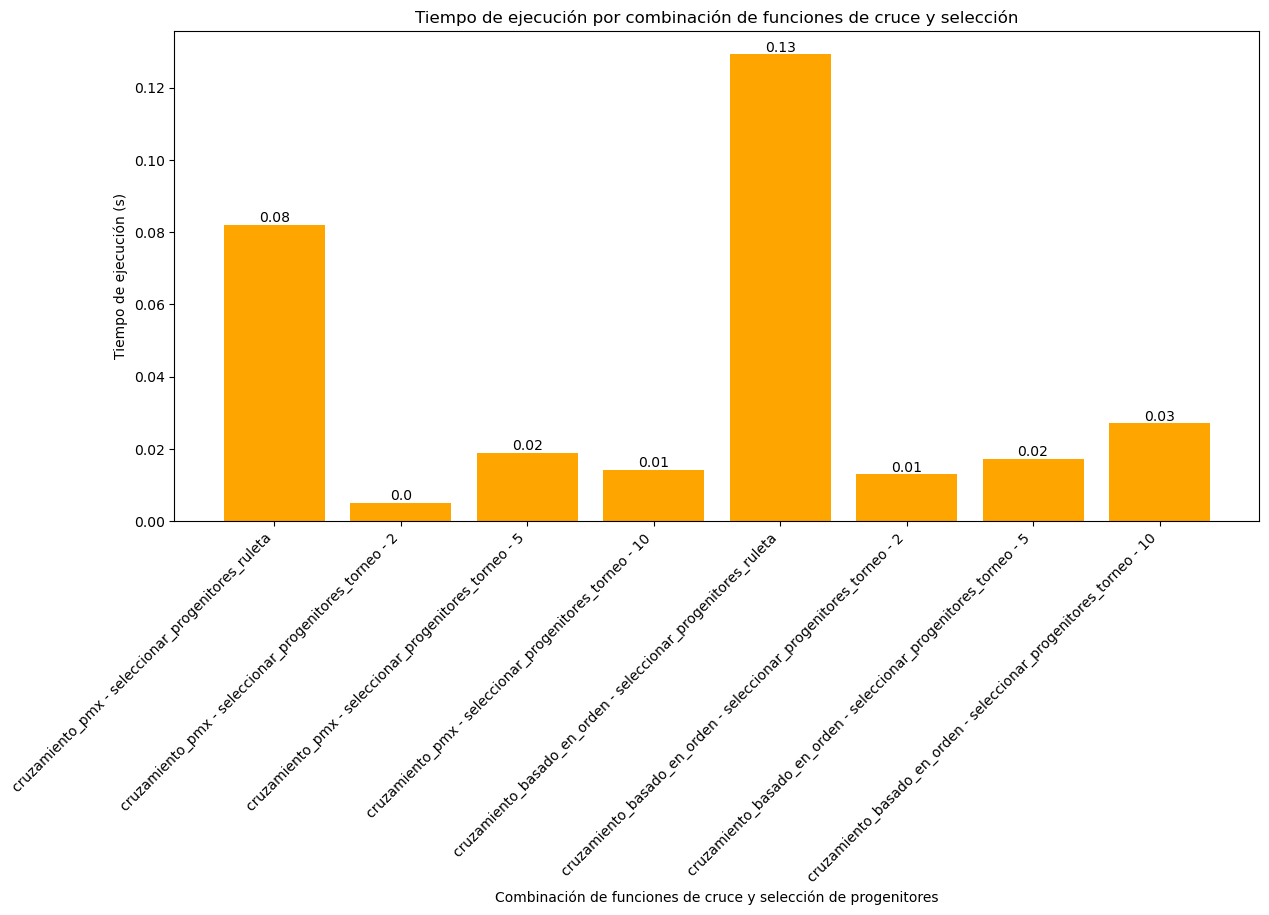

In [90]:
# Parámetros
tam_poblacion = 100
num_generaciones = 1000
ciudadInicial = "Pamplona"
valores_k = [2, 5, 10]

# Defino todas las funciones de cruce y selección de progenitores
funciones_seleccion = {
    seleccionar_progenitores_ruleta: "seleccionar_progenitores_ruleta",
    seleccionar_progenitores_torneo: "seleccionar_progenitores_torneo"
}

funciones_cruce = {
    cruzamiento_pmx: "cruzamiento_pmx",
    cruzamiento_basado_en_orden: "cruzamiento_basado_en_orden"
}

# Ejecuto el algoritmo genético con todas las combinaciones de funciones de cruce, selección de progenitores y valores de k
resultados_sin_mutaciones = ejecutar_algoritmo_genetico_sin_mutaciones(tam_poblacion, num_generaciones, ciudadInicial, valores_k, funciones_cruce, funciones_seleccion)

# Grafico evolución de costos sin mutaciones
graficar_evolucion_costos(resultados_sin_mutaciones, "evolucion_costos_sin_mutaciones.png")

# Grafico resultados sin mutaciones
graficar_resultados(resultados_sin_mutaciones, "resultados_sin_mutaciones.png")

# Grafico número de iteraciones sin mutaciones
graficar_numero_iteraciones(resultados_sin_mutaciones, "numero_iteraciones_sin_mutaciones.png")

# Grafico tiempo de ejecución sin mutaciones
graficar_tiempo_ejecucion(resultados_sin_mutaciones, "tiempo_ejecucion_sin_mutaciones.png")

### Algoritmo genetico con mutaciones

Función de cruce: cruzamiento_pmx
Función de selección de progenitores: seleccionar_progenitores_ruleta
Mejor ruta encontrada: ['Pamplona', 'Donostia', 'Zaragoza', 'Barcelona', 'Girona', 'Tarragona', 'Valencia', 'Alicante', 'Murcia', 'Cordoba', 'Sevilla', 'Cadiz', 'Huelva', 'Caceres', 'Toledo', 'Madrid', 'Leon', 'Coruna', 'Oviedo', 'Bilbao', 'Pamplona']
Costo de la mejor ruta: 4500
Iteración de mejor resultado: 190
Tiempo en que se encontró el mejor resultado: 0.5478758811950684

-----------------------------

Función de cruce: cruzamiento_pmx
Función de selección de progenitores: seleccionar_progenitores_torneo
Valor de k: 2
Mejor ruta encontrada: ['Pamplona', 'Bilbao', 'Oviedo', 'Coruna', 'Leon', 'Toledo', 'Cordoba', 'Sevilla', 'Cadiz', 'Huelva', 'Caceres', 'Madrid', 'Zaragoza', 'Barcelona', 'Girona', 'Tarragona', 'Valencia', 'Alicante', 'Murcia', 'Donostia', 'Pamplona']
Costo de la mejor ruta: 5261
Iteración de mejor resultado: 28
Tiempo en que se encontró el mejor resultado: 0.0758

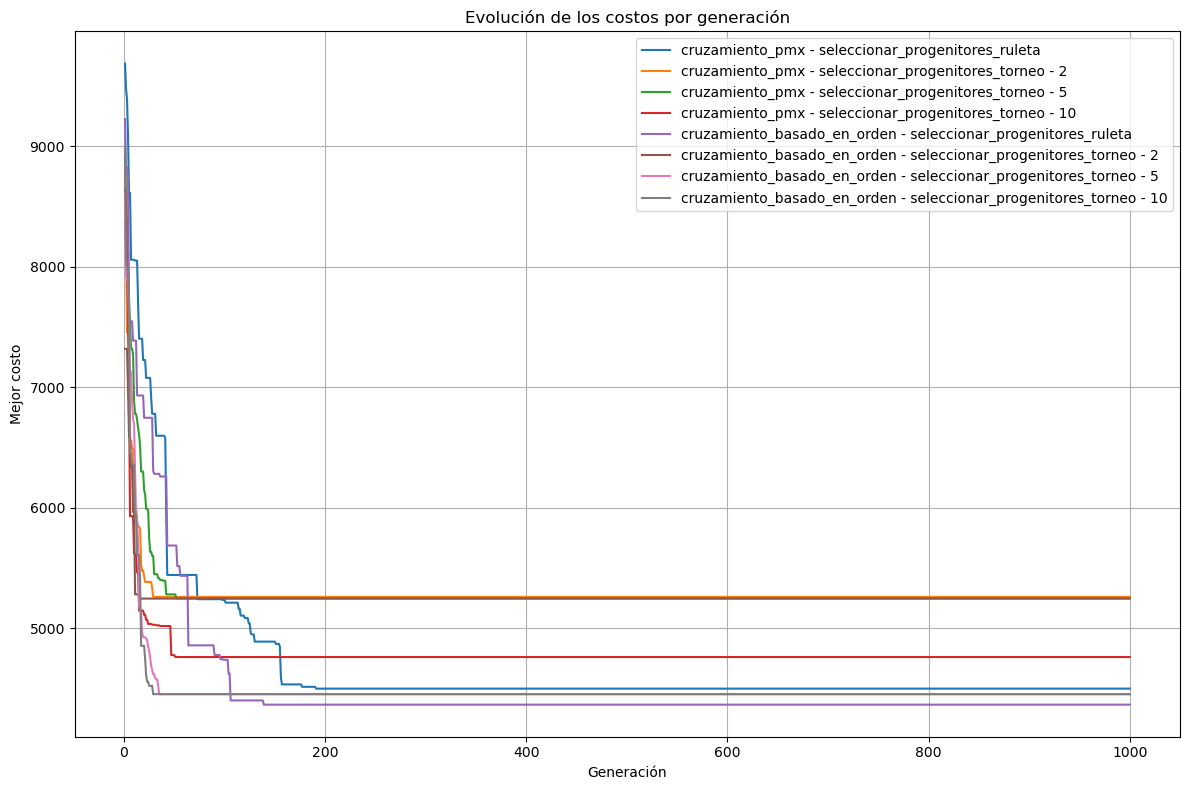

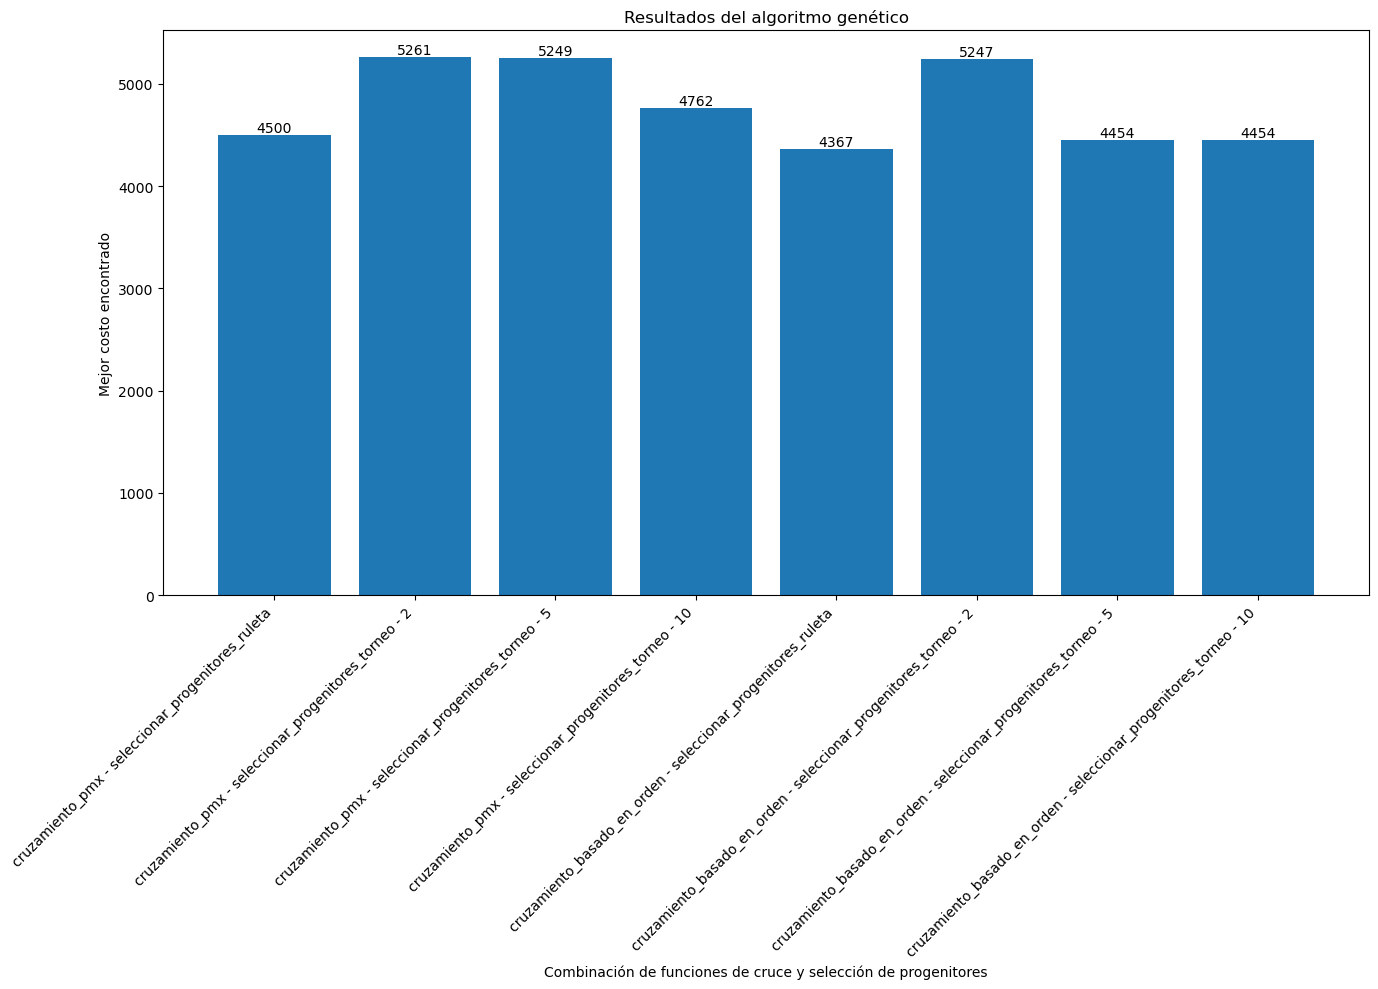

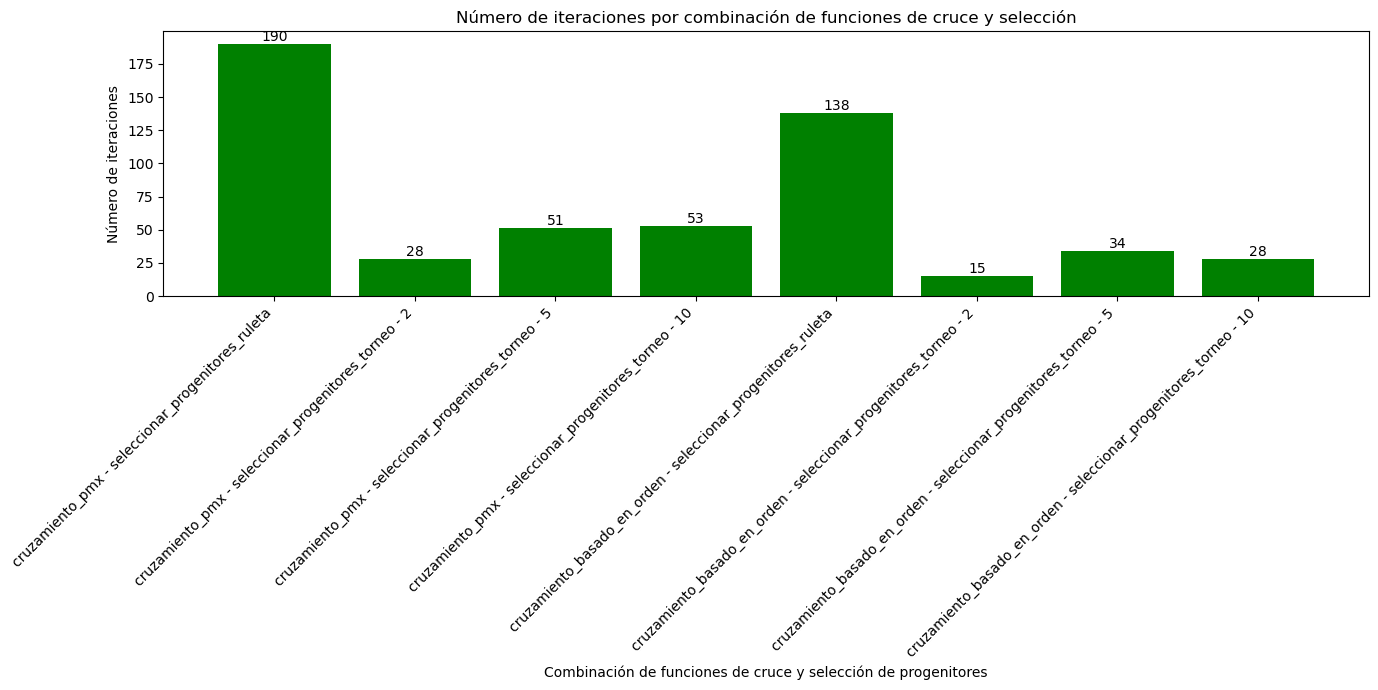

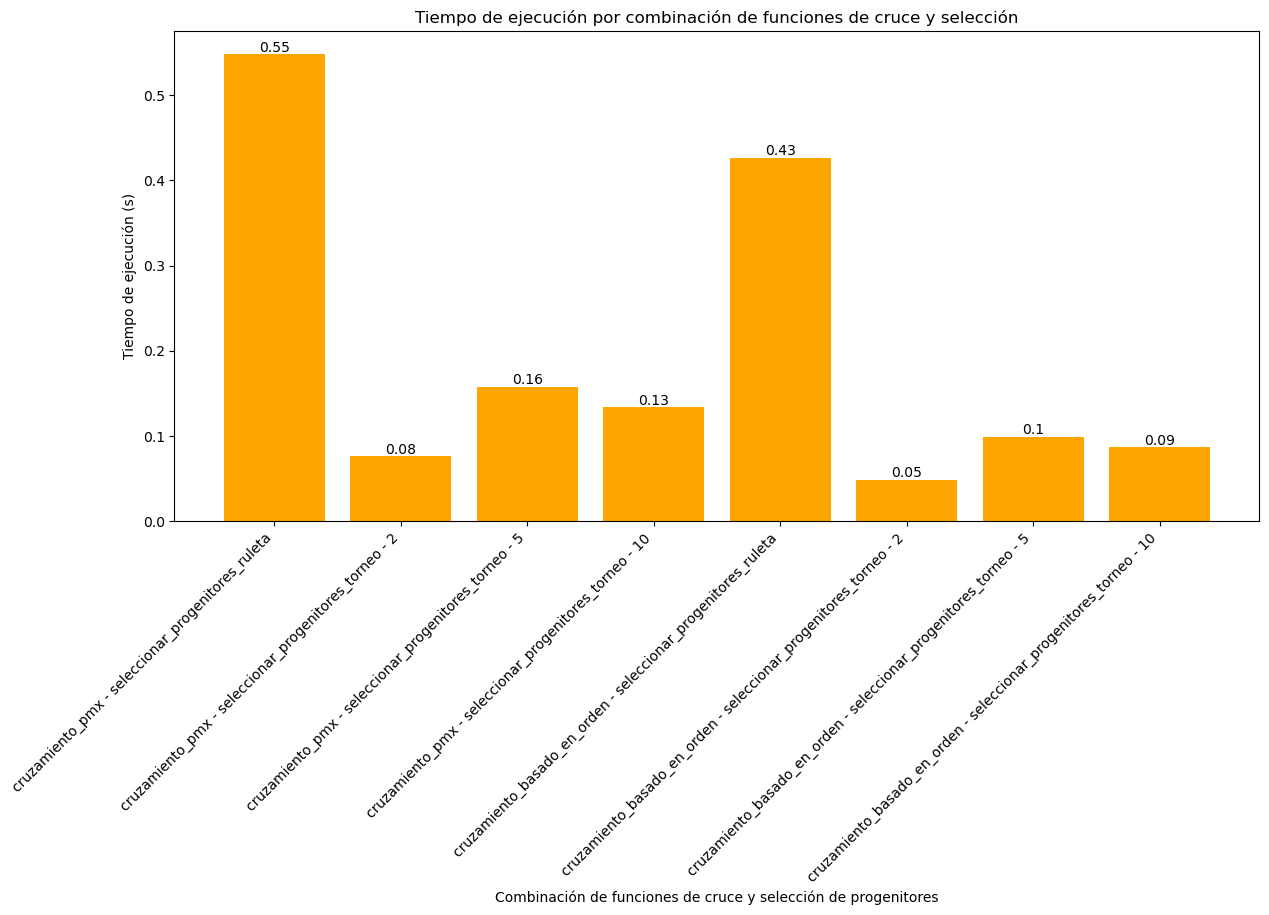

In [93]:
# Parámetros
tam_poblacion = 100
num_generaciones = 1000
ciudadInicial = "Pamplona"
valores_k = [2, 5, 10]

# Defino todas las funciones de cruce y selección de progenitores
funciones_seleccion = {
    seleccionar_progenitores_ruleta: "seleccionar_progenitores_ruleta",
    seleccionar_progenitores_torneo: "seleccionar_progenitores_torneo"
}

funciones_cruce = {
    cruzamiento_pmx: "cruzamiento_pmx",
    cruzamiento_basado_en_orden: "cruzamiento_basado_en_orden"
}

# Ejecuto el algoritmo genético con todas las combinaciones de funciones de cruce, selección de progenitores y valores de k
resultados_con_mutaciones = ejecutar_algoritmo_genetico_mutaciones(tam_poblacion, num_generaciones, ciudadInicial, valores_k, funciones_cruce, funciones_seleccion)

# Grafico evolución de costos con mutaciones
graficar_evolucion_costos(resultados_con_mutaciones, "evolucion_costos_con_mutaciones.png")

# Grafico resultados con mutaciones
graficar_resultados(resultados_con_mutaciones, "resultados_con_mutaciones.png")

# Grafico número de iteraciones con mutaciones
graficar_numero_iteraciones(resultados_con_mutaciones, "numero_iteraciones_con_mutaciones.png")

# Grafico tiempo de ejecución con mutaciones
graficar_tiempo_ejecucion(resultados_con_mutaciones, "tiempo_ejecucion_con_mutaciones.png")